# Libraries and data load

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


# Data Preparation

Check null count and dtype

In [4]:
null_counts_per_column = df.isnull().sum()

for col in df.columns:
    if null_counts_per_column[col] > 0:
        print(f"{col} ({df[col].dtype}): {null_counts_per_column[col]} nulls")

lead_source (object): 128 nulls
industry (object): 134 nulls
annual_income (float64): 181 nulls
employment_status (object): 100 nulls
location (object): 63 nulls


Fill nulls

In [5]:
for col in df.columns:
    if null_counts_per_column[col] > 0:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(0.0)
        else:
            df[col] = df[col].fillna('NA')

# Questions

## Q1: What is the most frequent observation (mode) for the column industry?

In [6]:
print(f'Most frequent obeservation   :   {df.industry.mode()[0]}')

Most frequent obeservation   :   retail


## Q2: What are the two features that have the biggest correlation?

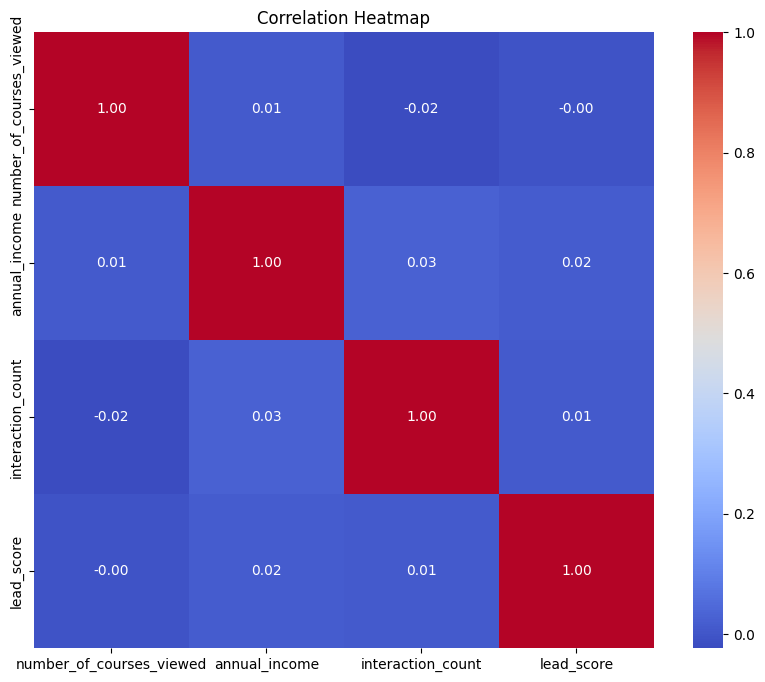

In [7]:
corr = df.drop(columns=['converted']).corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [8]:
corr_unstacked = corr.unstack().sort_values(ascending=False)
corr_unstacked = corr_unstacked[corr_unstacked < 1]

corr_unstacked_abs = corr_unstacked.abs()

highest_corr_pair = corr_unstacked_abs.idxmax()
highest_corr_value = corr.loc[highest_corr_pair]

print(f"Strongest correlation: {highest_corr_pair} = {highest_corr_value:.2f}")


Strongest correlation: ('annual_income', 'interaction_count') = 0.03


### Split the data

In [9]:
target_column = 'converted'

y = df[target_column]
X = df.drop(columns=[target_column])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 877, Val: 292, Test: 293


## Q3: Mutual information score

In [10]:
categorical = df.select_dtypes(exclude='number').columns
mi_scores = {}

for col in categorical:
    le = LabelEncoder()
    X_encoded = le.fit_transform(X_train[col])
    
    score = mutual_info_classif(
        X_encoded.reshape(-1, 1), y_train, discrete_features=True, random_state=42
    )[0]
    mi_scores[col] = round(score, 2)

In [11]:
print("Mutual Information Scores:")
for col, score in mi_scores.items():
    print(f"{col}: {score}")

Mutual Information Scores:
lead_source: 0.03
industry: 0.02
employment_status: 0.02
location: 0.0


In [12]:
best_feature = max(mi_scores, key=mi_scores.get)
print(f"\n✅ Highest mutual information: {best_feature} ({mi_scores[best_feature]})")


✅ Highest mutual information: lead_source (0.03)


## Q4: Logistic regression

In [13]:
categorical_cols = X_train.select_dtypes(exclude='number').columns

X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_val_encoded = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)

X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

In [14]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_encoded, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [15]:
y_val_pred = model.predict(X_val_encoded)
accuracy = accuracy_score(y_val, y_val_pred)
accuracy = round(accuracy, 2)

print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.74


## Q5: Least useful feature

In [16]:
base_accuracy = accuracy
features_to_test = ['industry', 'employment_status', 'lead_score']
diff_scores = {}

In [17]:
for feature in features_to_test:
    X_train_tmp = X_train_encoded.copy()
    X_val_tmp = X_val_encoded.copy()
    
    if feature in categorical_cols:
        drop_cols = [col for col in X_train_tmp.columns if col.startswith(feature + "_")]
        X_train_tmp.drop(columns=drop_cols, inplace=True)
        X_val_tmp.drop(columns=drop_cols, inplace=True)
    else:
        X_train_tmp.drop(columns=[feature], inplace=True)
        X_val_tmp.drop(columns=[feature], inplace=True)
    
    model_tmp = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model_tmp.fit(X_train_tmp, y_train)
    y_val_pred_tmp = model_tmp.predict(X_val_tmp)
    
    acc_tmp = accuracy_score(y_val, y_val_pred_tmp)
    diff_scores[feature] = base_accuracy - acc_tmp

In [18]:
for feature, diff in diff_scores.items():
    print(f"{feature}: difference = {diff:.4f}")

industry: difference = -0.0032
employment_status: difference = -0.0066
lead_score: difference = -0.0032


In [19]:
least_useful = min(diff_scores, key=lambda x: abs(diff_scores[x]))
print(f"\nLeast useful feature: {least_useful}")


Least useful feature: industry


## Q6: Regularized logistic regression

In [20]:
C_values = [0.01, 0.1, 1, 10, 100]
accuracy_scores = {}

In [21]:
for C in C_values:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train_encoded, y_train)
    y_val_pred = model.predict(X_val_encoded)
    acc = accuracy_score(y_val, y_val_pred)
    accuracy_scores[C] = round(acc, 3)
    print(f"C={C}: Validation Accuracy = {accuracy_scores[C]}")

C=0.01: Validation Accuracy = 0.74
C=0.1: Validation Accuracy = 0.743
C=1: Validation Accuracy = 0.743
C=10: Validation Accuracy = 0.743
C=100: Validation Accuracy = 0.743


In [22]:
max_acc = max(accuracy_scores.values())
best_C = min([C for C, acc in accuracy_scores.items() if acc == max_acc])
print(f"\n✅ Best C: {best_C} with accuracy {max_acc}")


✅ Best C: 0.1 with accuracy 0.743


---- End ----